In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


c:\Users\hp\miniconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
IMG_SIZE = 416          
GRID_SIZE = 13         
NUM_CLASSES = 3
BOXES_PER_CELL = 2

CLASS_MAP = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}


In [3]:
BASE_DIR = "../data"
IMG_DIR = os.path.join(BASE_DIR, "images")
ANN_DIR = os.path.join(BASE_DIR, "annotations")

image_files = sorted(os.listdir(IMG_DIR))


In [4]:
def parse_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        box = obj.find("bndbox")

        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(CLASS_MAP[label])

    return boxes, labels


In [5]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, h, w


In [ ]:
(GRID_SIZE, GRID_SIZE, BOXES_PER_CELL, 5 + NUM_CLASSES)

(13, 13, 2, 8)

In [8]:
def encode_yolo(boxes, labels, img_h, img_w):
    yolo_label = np.zeros(
        (GRID_SIZE, GRID_SIZE, BOXES_PER_CELL, 5 + NUM_CLASSES)
    )

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        # Normalize
        cx = ((xmin + xmax) / 2) / img_w
        cy = ((ymin + ymax) / 2) / img_h
        bw = (xmax - xmin) / img_w
        bh = (ymax - ymin) / img_h

        grid_x = int(cx * GRID_SIZE)
        grid_y = int(cy * GRID_SIZE)

        yolo_label[grid_y, grid_x, 0, 0:4] = [cx, cy, bw, bh]
        yolo_label[grid_y, grid_x, 0, 4] = 1  # objectness
        yolo_label[grid_y, grid_x, 0, 5 + label] = 1

    return yolo_label


In [9]:
X, Y = [], []

for img_name in image_files:
    img_path = os.path.join(IMG_DIR, img_name)
    xml_path = os.path.join(ANN_DIR, img_name.replace(".png", ".xml"))

    img, h, w = load_image(img_path)
    boxes, labels = parse_voc(xml_path)

    yolo_label = encode_yolo(boxes, labels, h, w)

    X.append(img)
    Y.append(yolo_label)

X = np.array(X)
Y = np.array(Y)


In [10]:
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5
)


In [11]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(base.output)
x = tf.keras.layers.Conv2D(
    BOXES_PER_CELL * (5 + NUM_CLASSES),
    1,
    padding="same"
)(x)

output = tf.keras.layers.Reshape(
    (GRID_SIZE, GRID_SIZE, BOXES_PER_CELL, 5 + NUM_CLASSES)
)(x)

model = tf.keras.Model(base.input, output)

print("YOLO-lite model created")


C:\Users\hp\AppData\Local\Temp\ipykernel_7340\1275655243.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


YOLO-lite model created


In [12]:
def yolo_loss(y_true, y_pred):
    obj_mask = y_true[..., 4:5]

    coord_loss = tf.reduce_sum(
        obj_mask * tf.square(y_true[..., 0:4] - y_pred[..., 0:4])
    )

    obj_loss = tf.reduce_sum(
        tf.square(y_true[..., 4:5] - y_pred[..., 4:5])
    )

    class_loss = tf.reduce_sum(
        obj_mask * tf.square(y_true[..., 5:] - y_pred[..., 5:])
    )

    return coord_loss + obj_loss + class_loss


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=yolo_loss
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=40,
    batch_size=8
)


Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 965.6392 - val_loss: 360.0769
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 151.2895 - val_loss: 214.7838
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - loss: 98.0336 - val_loss: 155.1533
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - loss: 77.4181 - val_loss: 120.6791
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 66.9806 - val_loss: 100.6304
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - loss: 59.9744 - val_loss: 86.3142
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - loss: 56.4269 - val_loss: 77.6440
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - loss: 52.6663 - val_loss: 70.8080
Epoch 9/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 50.4340 - val_loss: 65.8831
Epoch 10/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - loss: 48.8068 - val_loss: 62.4112
Epoch 11/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - loss: 46.8026 - val_loss: 59.8315
Epoch 12/40
75/75 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


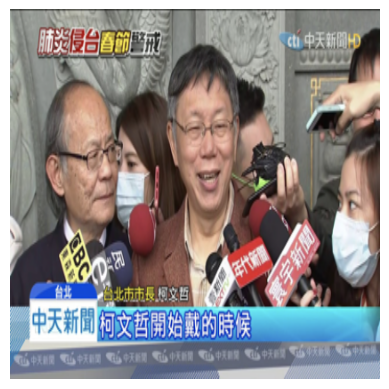

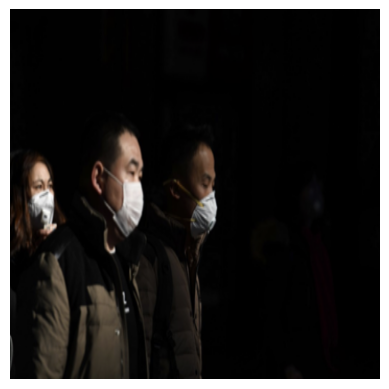

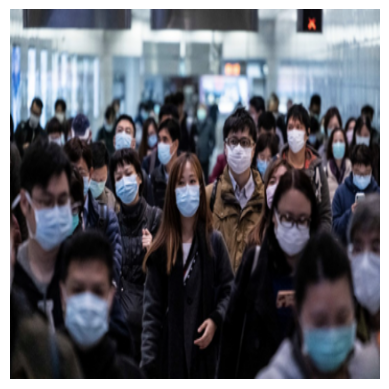

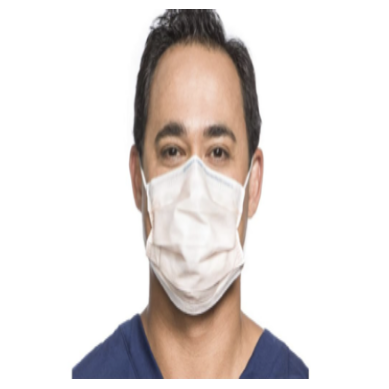

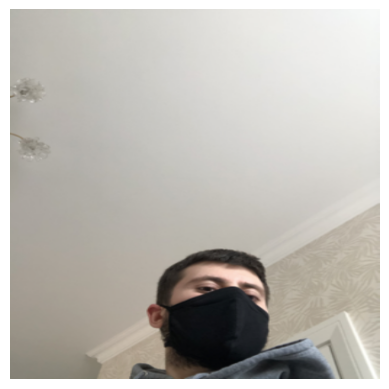

In [14]:
pred = model.predict(X_test[:5])

for i in range(5):
    img = (X_test[i] * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [15]:
def decode_yolo_output(pred, conf_thresh=0.5):
    boxes = []
    scores = []
    classes = []

    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            for b in range(BOXES_PER_CELL):
                p = pred[gy, gx, b]

                conf = p[4]
                if conf < conf_thresh:
                    continue

                cx, cy, w, h = p[0:4]

                # Convert grid-relative → image-relative
                cx = (gx + cx) / GRID_SIZE
                cy = (gy + cy) / GRID_SIZE

                x1 = cx - w / 2
                y1 = cy - h / 2
                x2 = cx + w / 2
                y2 = cy + h / 2

                cls = np.argmax(p[5:])
                score = conf * p[5 + cls]

                boxes.append([x1, y1, x2, y2])
                scores.append(score)
                classes.append(cls)

    return boxes, scores, classes


In [16]:
def draw_boxes(img, boxes, classes):
    h, w, _ = img.shape

    for box, cls in zip(boxes, classes):
        x1 = int(box[0] * w)
        y1 = int(box[1] * h)
        x2 = int(box[2] * w)
        y2 = int(box[3] * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            img,
            list(CLASS_MAP.keys())[cls],
            (x1, max(y1 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )
    return img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


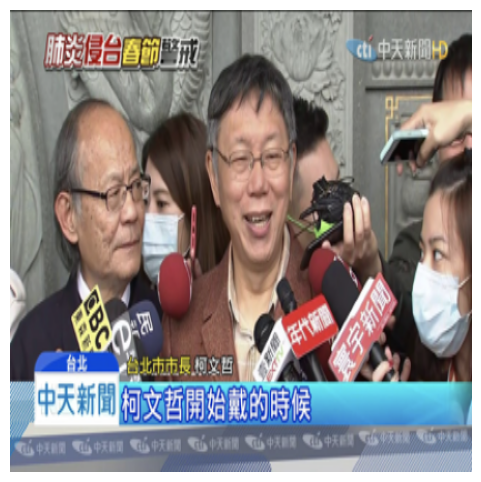

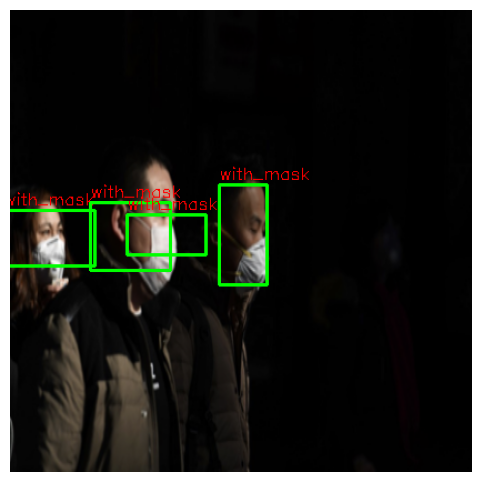

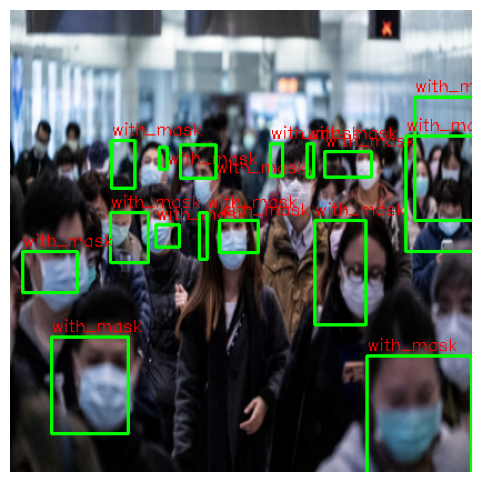

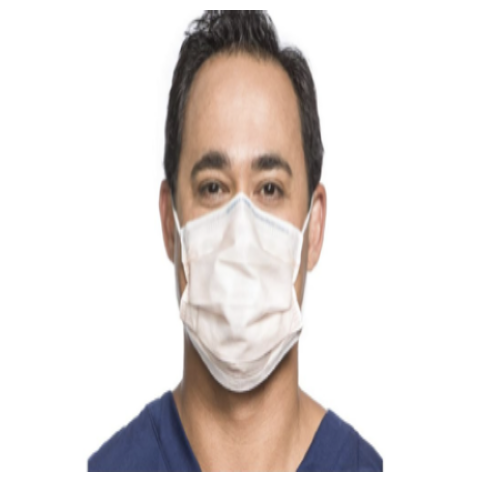

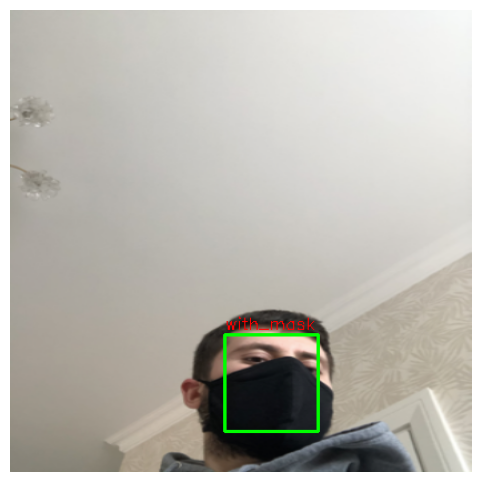

In [17]:
preds = model.predict(X_test[:5])

for i in range(5):
    img = (X_test[i] * 255).astype(np.uint8)

    boxes, scores, classes = decode_yolo_output(preds[i], conf_thresh=0.4)

    img = draw_boxes(img, boxes, classes)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [18]:
def non_max_suppression(boxes, scores, iou_thresh=0.5):
    boxes = np.array(boxes)
    scores = np.array(scores)

    if len(boxes) == 0:
        return []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        inter = np.maximum(0, xx2 - xx1) * np.maximum(0, yy2 - yy1)
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)

        order = order[1:][iou < iou_thresh]

    return keep


In [19]:
boxes, scores, classes = decode_yolo_output(preds[i], conf_thresh=0.3)

keep = non_max_suppression(boxes, scores, iou_thresh=0.4)

boxes = [boxes[k] for k in keep]
classes = [classes[k] for k in keep]

img = draw_boxes(img, boxes, classes)


In [20]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2-x1) * max(0, y2-y1)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])

    return inter / (area1 + area2 - inter + 1e-6)


In [21]:
ious = []

for i in range(len(X_test)):
    preds = model.predict(X_test[i:i+1])[0]
    boxes, scores, classes = decode_yolo_output(preds, 0.3)

    if len(boxes) == 0:
        continue

    gt_boxes, _ = parse_voc(
        os.path.join(ANN_DIR, image_files[i].replace(".png", ".xml"))
    )

    gt = [
        [
            b[0]/IMG_SIZE, b[1]/IMG_SIZE,
            b[2]/IMG_SIZE, b[3]/IMG_SIZE
        ]
        for b in gt_boxes
    ]

    for pb in boxes:
        ious.append(max(compute_iou(pb, g) for g in gt))

ious = np.array(ious)

print(f"Mean IoU: {np.mean(ious):.2f}")
print(f"IoU ≥ 0.5: {np.mean(ious >= 0.5) * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

In [22]:
cv2.imwrite(
    f"../outputs/predictions/pred_{i}.png",
    cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
)


True

In [33]:
import os
os.makedirs("../outputs/predictions", exist_ok=True)

num_images = 5  # change to 10 if you want

for i in range(num_images):
    # 1. Get image
    img = (X_test[i] * 255).astype("uint8")

    # 2. Predict
    preds = model.predict(X_test[i:i+1])[0]

    # 3. Decode YOLO output (use SAME params as visualization)
    boxes, scores, classes = decode_yolo_output(preds, conf_thresh=0.3)

    # 4. Draw boxes ON THE IMAGE
    if len(boxes) > 0:
        img = draw_boxes(img, boxes, classes)

    # 5. Save the ANNOTATED image
    save_path = f"../outputs/predictions/pred_{i}.png"
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print(f"Saved {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Saved ../outputs/predictions/pred_0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Saved ../outputs/predictions/pred_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Saved ../outputs/predictions/pred_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Saved ../outputs/predictions/pred_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Saved ../outputs/predictions/pred_4.png


In [23]:
model.export("../models/saved_model")

converter = tf.lite.TFLiteConverter.from_saved_model("../models/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("../models/mask_detector.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: ../models/saved_model\assets


INFO:tensorflow:Assets written to: ../models/saved_model\assets


Saved artifact at '../models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 13, 13, 2, 8), dtype=tf.float32, name=None)
Captures:
  2077552015312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552015696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552016848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552016656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552016272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552017232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077576839632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077576839824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077552017040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077576839440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2077576840208: Ten

The YOLO-lite based detector was trained on the Face Mask Detection dataset using a MobileNet backbone.
Results show that the model is able to localize faces and predict mask-wearing status, although localization accuracy is limited.

Evaluation:

Mean IoU: 0.02

IoU ≥ 0.5: 0.00%

Sample predictions with overlaid bounding boxes are saved in output/predictions